In [36]:
import numpy as np
from itertools import product,combinations
import matplotlib.pyplot as plt

from functools import partial
import sobol_seq
import re

**Problem 1 Pak Kun**

In [37]:
epsilon = 1e-3
delta = 1e-2
dim = 2
mutation_rate = 0.1

gamma = -0.2
m_cluster = 100
k_cluster = 10
m = 100
k_max = 1000
seed = np.random.randint(0,100)
print(f"seed={seed}")

def objective_function(x):
    f1 = np.exp(x[0]-x[1])-np.sin(x[0]+x[1])
    f2 = (x[0]*x[1])**2-np.cos(x[0]+x[1])
    return np.array([f1,f2])

boundaries = np.array([(-10,10) for _ in range (dim)])

seed=25


# Root Objective Function

In [38]:
def root_objective_function(x:np.ndarray):
    F_array = objective_function(x)
    denom = 0
    for f in F_array:
        denom +=np.abs(f)
    F = 1/(1+denom)
    return -F

# Optimization Algorithm

In [39]:
"""GENERATE POINTS USING SOBOL SEQUENCE"""
def generate_points(dim: int,
                    npoint:int,
                    low=-10,
                    high=10,
                    sobol = True):
    if type(low) != type(high):
        raise TypeError('The type of "low" and "high" should be the same.')
    if type(low) == int:
        boundaries = [(low,high) for _ in range (dim)]
    elif type(low) == list or type(low) == np.ndarray:
        if len(low) != len(high):
            raise TypeError('The length of "low" and "high" should be the same.')
        else:
            boundaries = [(low[i],high[i]) for i in range (len(low))]

    if sobol == True:
        # Generate Sobol sequence points
        sobol_points = sobol_seq.i4_sobol_generate(dim, npoint)
        # Scale the Sobol points to fit within the specified boundaries
        scaled_points = []
        for i in range(dim):
            a, b = boundaries[i]
            scaled_dim = a + sobol_points[:, i] * (b - a)
            scaled_points.append(scaled_dim)
        # Transpose the scaled points to get points per dimension
        scaled_points = np.array(list(map(list, zip(*scaled_points))))
    
    else:
        scaled_points = np.zeros((npoint, dim))
        for i in range(dim):
            min_val, max_val = boundaries[i]
            scaled_points[:, i] = np.random.uniform(min_val, max_val, npoint)

    return scaled_points


In [40]:
k=0
iter_points = {}
iter_points[k] = generate_points(dim,m_cluster,boundaries[:,0],boundaries[:,1])
fitness = np.asarray([root_objective_function(ind) for ind in iter_points[0]])
best_idx = np.argmin(fitness)
x_prime = iter_points[0][best_idx]

radius = (boundaries[:,1]-boundaries[:,0])/2
id_rad = np.argmin(radius)
radii = radius[id_rad]

cluster_center,cluster_radius = np.array([x_prime]),np.array([radii])
# cluster_center[0],cluster_radius[0] = x_prime,radius
print(cluster_center,cluster_radius)

[[-1.25  1.25]] [10.]


In [41]:
"""FUNCTION CLUSTER"""
def function_cluster(y):
    # min_dist_cluster = 10**100
    # for ci,cc in cluster_center.items():
    #     dist = np.linalg.norm(cc-y)
    #     if dist<=min_dist_cluster:
    #         xc = cc
    #         cluster_id = ci
    #         min_dist_cluster = dist
    global cluster_center
    global cluster_radius
    dist_list = np.linalg.norm(cluster_center-y,axis=1)
    min_dist_id = np.argmin(dist_list)
    min_dist = dist_list[min_dist_id]
    xc = cluster_center[min_dist_id]
    xt = (xc + y)/2
    # print(xt,xc,y)
    Fxt = root_objective_function(xt)
    Fxc = root_objective_function(xc)
    Fy = root_objective_function(y)
    # print(Fxt,Fxc,Fy)
    if (Fxt > Fy) & (Fxt > Fxc):
        cluster_center = np.append(cluster_center,[y],axis=0)
        cluster_radius = np.append(cluster_radius, [np.linalg.norm(y-xt)],axis=0)
    elif (Fxt < Fy) & (Fxt < Fxc):
        cluster_center = np.append(cluster_center,[y],axis=0)
        cluster_radius = np.append(cluster_radius, [np.linalg.norm(y-xt)],axis=0)
        function_cluster(xt)
    elif Fy < Fxc:
        cluster_center[min_dist_id] = y
    
    # update radii if the existing corresponding cluster radii is larger than tha candidate
    if cluster_radius[min_dist_id] > np.linalg.norm(y-xt):
        cluster_radius[min_dist_id] =  np.linalg.norm(y-xt)
    
    # return cluster_center,cluster_radius


In [42]:
import importlib.util

spec = importlib.util.spec_from_file_location("gal", r"D:\OneDrive - Institut Teknologi Bandung\[AKADEMIK]\Semester 7-8\TA\Thesis\Genetic Algorithm\genal.py")
gal = importlib.util.module_from_spec(spec)
spec.loader.exec_module(gal)

In [43]:
while k<k_cluster:
    potential_cluster_center = []
    F = root_objective_function(iter_points[k].T)
    for i in range (m_cluster):
        # If F(x_i)<gamma and x_i is not the center of existing cluster, x_i may have a possibility to become a cluster center
        if len(iter_points[k].T) == 1:
            fungam = F[0][i]
        else:
            fungam = F[i]
        exist_in_cluster_center = any(np.linalg.norm(iter_points[k][i] - ctr) < epsilon for ctr in cluster_center)
        if (fungam < gamma) & (exist_in_cluster_center==False):
            potential_cluster_center.append(iter_points[k][i])
        # print(f'potential_cluster_center:{potential_cluster_center}')
    # Apply function cluster
    for i in range (len(potential_cluster_center)):
        function_cluster(potential_cluster_center[i])
    fitness_k = np.asarray([root_objective_function(ind) for ind in iter_points[k]])
    i_g = np.argmin(fitness)
    x_i_g = iter_points[k][i_g]
    iter_points[k+1] = np.copy(iter_points[k])
    fitness_k = np.asarray([root_objective_function(ind) for ind in iter_points[k]])
    selected_population = gal.selection(population=iter_points[k+1],fitness=fitness_k)
    offspring_population = gal.recombination(population=selected_population,
                                             mutation_rate=mutation_rate,
                                             boundaries=boundaries)
    iter_points[k+1] = offspring_population
    

    k+=1
print(f"len(cluster_center)={len(cluster_center)}\ncluster_center={cluster_center}")
print(f"len(cluster_radius)={len(cluster_radius)}\ncluster_radius={cluster_radius}")

len(cluster_center)=29
cluster_center=[[-0.98979635  1.015625  ]
 [ 0.3089293   0.01922427]
 [-0.48828125  0.7421875 ]
 [-3.359375    0.0390625 ]
 [-0.18479038  6.6015625 ]
 [-1.1466854   1.25      ]
 [-1.0420927   1.09375   ]
 [-9.09770431  0.03844855]
 [-2.8125      0.46875   ]
 [-2.86571878 -0.1583833 ]
 [ 0.19833849  1.5625    ]
 [-0.078125    1.09375   ]
 [-0.3515625   0.859375  ]
 [ 0.19833849  6.71875   ]
 [-0.05708076  6.640625  ]
 [ 0.6178586   0.03844855]
 [-1.3921338  -0.1583833 ]
 [-7.68972826  0.03844855]
 [-8.15905361  0.03844855]
 [-6.13671184 -0.1583833 ]
 [-6.69535923 -0.13378324]
 [-5.625      -0.16556496]
 [-6.80934454 -0.1583833 ]
 [-6.73335434 -0.14198326]
 [-7.29073246 -0.1583833 ]
 [-7.5052315  -0.05996738]
 [-5.625      -0.18710994]
 [-5.625      -0.17274662]
 [-1.31855995 -0.1583833 ]]
len(cluster_radius)=29
cluster_radius=[0.04700645 0.10461212 0.09003461 0.09935256 0.06677504 0.15625
 0.09401289 0.09841593 0.62986389 0.0815233  0.13520576 0.36013846
 0.180069

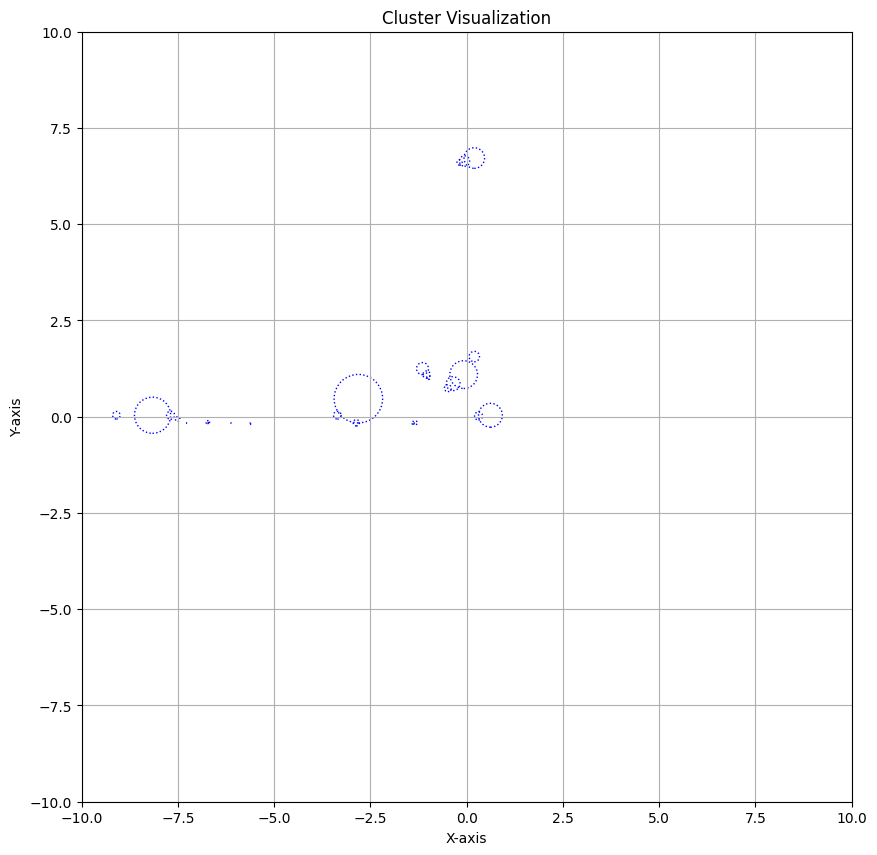

In [44]:
if dim != 2:
    print(f"Dimension {dim} can be visualized using cluster_visualization2D.")
"""Visualization"""
fig, ax = plt.subplots(figsize=(10,10))
for center,radius in zip(cluster_center,cluster_radius):
    circle = plt.Circle(center, radius, fill=False, linestyle='dotted', edgecolor='b')
    ax.add_artist(circle)

# Set axis limits
ax.set_xlim(boundaries[0])
ax.set_ylim(boundaries[1])
    
ax.autoscale_view()

# # Add labels (optional)
# for i, center in cluster_center.items():
#     ax.text(center[0], center[1], f'Cluster {i+1}', ha='center', va='bottom')

# Add a title and labels (optional)
ax.set_title('Cluster Visualization')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')  # Make the aspect ratio equal
plt.grid(True)
plt.show()

In [45]:
answ = np.array([[-6.437160, 0.155348],
                 [-0.932122, 1.067870],
                 [-0.155283, 6.439840],
                 [0.163333, 6.122430],
                 [0.667121, 0.690103],
                 [-6.117110, -0.163476]])

possible_cluster_id = []
for i in range (len(cluster_center)):
    for j in range (len(answ)):
        ddist = np.linalg.norm(cluster_center[i]-answ[j])
        if ddist <= cluster_radius[i]:
            possible_cluster_id.append([i,j])
            print(f'cluster_center[{i}] x answ[{j}]')


# SDGA Evaluation

In [46]:
archive = []
for i in range (len(cluster_center)):
    subbound = np.array([cluster_center[i]-cluster_radius[i],cluster_center[i]+cluster_radius[i]])
    root, root_score = gal.GA(objective_function=root_objective_function,
                              population_size=m,
                              boundaries=subbound,
                              max_generation=k_max,
                              mutation_rate=mutation_rate,
                              seed=seed)
    archive.append(root)
    print(f'\n====== Cluster {i} ======\n')
    print(f'Roots = {archive}')
archive


====== Cluster 0 ======

Roots = [array([0.66719716, 0.68981706])]

====== Cluster 1 ======

Roots = [array([0.66719716, 0.68981706]), array([0.20033256, 0.4125664 ])]

====== Cluster 2 ======

Roots = [array([0.66719716, 0.68981706]), array([0.20033256, 0.4125664 ]), array([0.65001939, 0.70759205])]

====== Cluster 3 ======

Roots = [array([0.66719716, 0.68981706]), array([0.20033256, 0.4125664 ]), array([0.65001939, 0.70759205]), array([-3.17065596, -0.01308313])]

====== Cluster 4 ======

Roots = [array([0.66719716, 0.68981706]), array([0.20033256, 0.4125664 ]), array([0.65001939, 0.70759205]), array([-3.17065596, -0.01308313]), array([0.67123536, 0.68604109])]

====== Cluster 5 ======

Roots = [array([0.66719716, 0.68981706]), array([0.20033256, 0.4125664 ]), array([0.65001939, 0.70759205]), array([-3.17065596, -0.01308313]), array([0.67123536, 0.68604109]), array([0.6705346 , 0.68658411])]

====== Cluster 6 ======

Roots = [array([0.66719716, 0.68981706]), array([0.20033256, 0.41

[array([0.66719716, 0.68981706]),
 array([0.20033256, 0.4125664 ]),
 array([0.65001939, 0.70759205]),
 array([-3.17065596, -0.01308313]),
 array([0.67123536, 0.68604109]),
 array([0.6705346 , 0.68658411]),
 array([0.6680719, 0.6893106]),
 array([-6.11686061, -0.16415768]),
 array([-0.98931614,  1.011243  ]),
 array([-1.44991193, -0.09184371]),
 array([0.66693723, 0.69018572]),
 array([0.66321095, 0.69410405]),
 array([0.66799189, 0.68940761]),
 array([0.68702557, 0.66920153]),
 array([0.66657688, 0.68969257]),
 array([0.29817344, 0.57366141]),
 array([-1.2859155 , -0.21307565]),
 array([-6.11568215, -0.1634597 ]),
 array([-6.11640733, -0.16410485]),
 array([-6.12093537, -0.16253398]),
 array([-6.11323328, -0.16567951]),
 array([-5.61154451, -0.16758858]),
 array([-6.11420153, -0.16415103]),
 array([-6.11440528, -0.16353031]),
 array([-6.11895189, -0.16318455]),
 array([-6.11961555, -0.16357354]),
 array([-5.62221843, -0.17403368]),
 array([-5.62303574, -0.17291647]),
 array([-1.1965996

Cluster Visualization

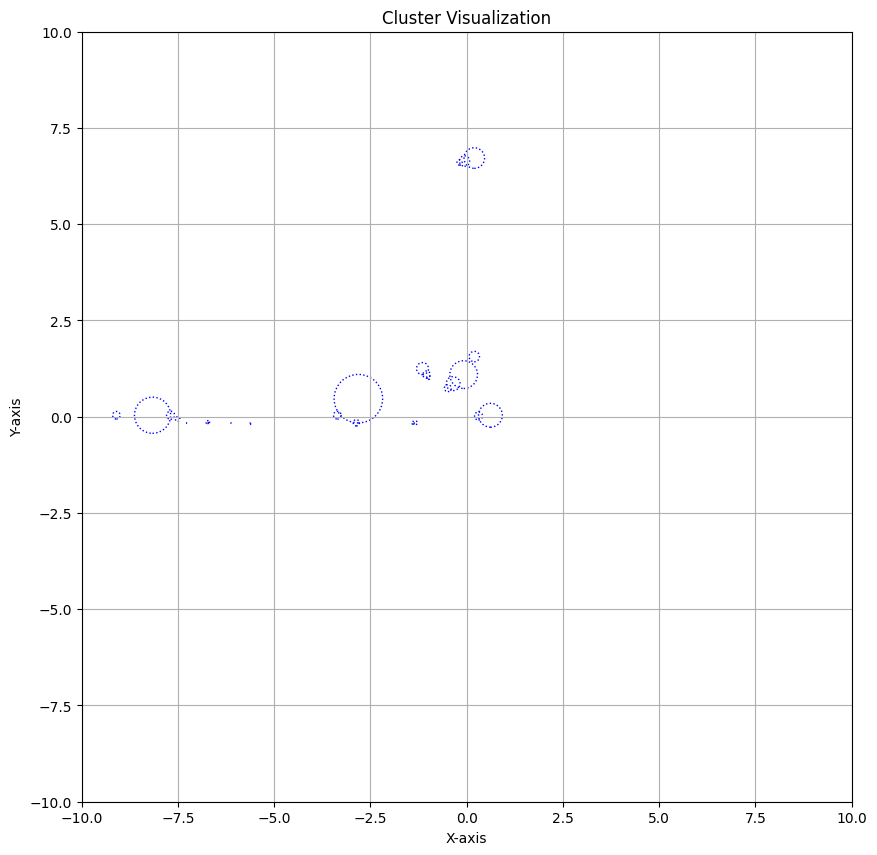

In [47]:
if dim != 2:
    print(f"Dimension {dim} can be visualized using cluster_visualization2D.")
"""Visualization"""
fig, ax = plt.subplots(figsize=(10,10))
for center,radius in zip(cluster_center,cluster_radius):
    circle = plt.Circle(center, radius, fill=False, linestyle='dotted', edgecolor='b')
    ax.add_artist(circle)

# Set axis limits
ax.set_xlim(boundaries[0])
ax.set_ylim(boundaries[1])
# ax.autoscale_view()

# # Add labels (optional)
# for i, center in cluster_center.items():
#     ax.text(center[0], center[1], f'Cluster {i+1}', ha='center', va='bottom')

# Add a title and labels (optional)
ax.set_title('Cluster Visualization')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')  # Make the aspect ratio equal
plt.grid(True)
plt.show()

In [48]:
answ = np.array([[-6.437160, 0.155348],
                 [-0.932122, 1.067870],
                 [-0.155283, 6.439840],
                 [0.163333, 6.122430],
                 [0.667121, 0.690103],
                 [-6.117110, -0.163476]])

possible_cluster_id = []
for i in range (len(cluster_center)):
    for j in range (len(answ)):
        ddist = np.linalg.norm(cluster_center[i]-answ[j])
        if ddist <= cluster_radius[i]:
            possible_cluster_id.append([i,j])
            print(f'cluster_center[{i}] x answ[{j}]')


In [49]:
if dim == 1:
    list_criteria = [element for sublist in archive for element in sublist] #convert from 2D array into 1D array
else:
    list_criteria = archive
eligible_roots = np.array([x for x in list_criteria if (root_objective_function(x))<-1+epsilon])
eligible_roots

array([[0.66719716, 0.68981706],
       [0.66693723, 0.69018572]])

In [50]:
id_duplicated_roots = []
for i in range(len(eligible_roots)):
    for j in range (i+1,len(eligible_roots)):
        if np.linalg.norm(eligible_roots[i]-eligible_roots[j])<delta:
            id_duplicated_roots.append([i,j])
id_duplicated_roots = np.unique(id_duplicated_roots,axis=0)
deselected_id_duplicated_roots = []
for i in range (len(id_duplicated_roots)):
    root_a = root_objective_function(eligible_roots[id_duplicated_roots[i][0]])
    root_b = root_objective_function(eligible_roots[id_duplicated_roots[i][1]])
    if root_a<=root_b:
        id_duplicated_root = id_duplicated_roots[i][1]
    else:
        id_duplicated_root = id_duplicated_roots[i][0]
    deselected_id_duplicated_roots.append(id_duplicated_root)

if deselected_id_duplicated_roots:
    unique_roots = np.ones(len(eligible_roots),dtype=bool)
    unique_roots[deselected_id_duplicated_roots] = False
    final_root = eligible_roots[unique_roots]
else:
    final_root = eligible_roots

final_root

array([[0.66693723, 0.69018572]])